<a href="https://colab.research.google.com/github/GabrielaRomoM/SIGNALS-THEORY_2024-1/blob/main/RedNeuronalPSD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler

# Definición de las señales y calculo del PSD (Welch)

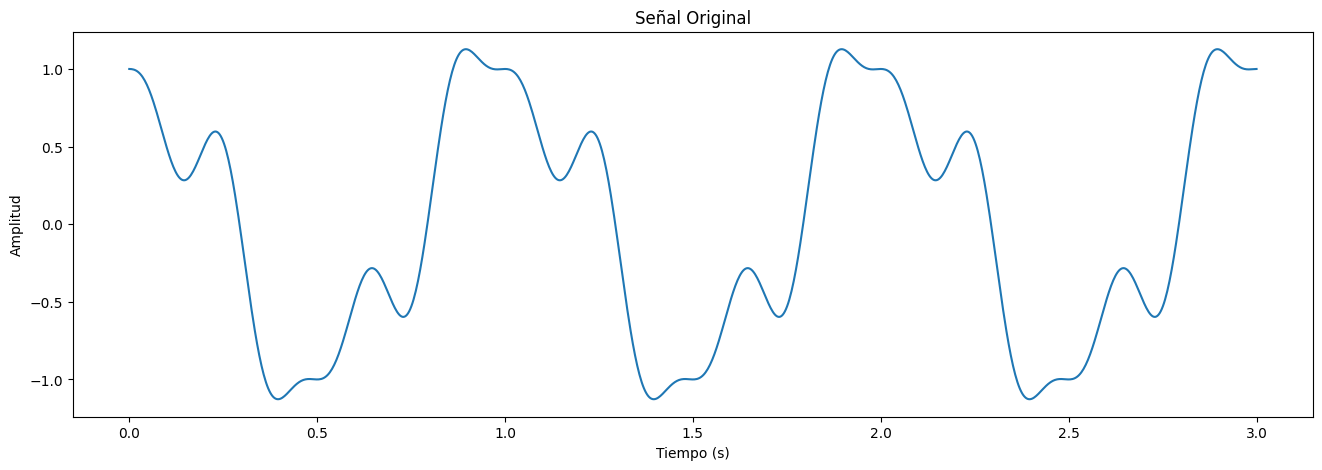

In [ ]:
#Creación de la señal original x(t)
#Frecuencia angular general y vector de tiempo
f = 1
w = 2*np.pi*f
T = 3  #Duración de la señal
N = 1024 #Puntos en la señal
fs = N/T #frecuencia de muestreo
t = np.linspace(0,T,N)

#Señales particulares
x1 = np.cos(w*t)
x2 = 1/3*(np.sin(3*w*t))
x3 = 1/5*(np.sin(5*w*t))

#Señal original para la red
xt = x1-x2+x3

plt.figure(figsize=(16,5))
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.plot(t,xt)
plt.show()

In [ ]:
#Generador de ruido blanco gausiano para crear la matriz con señales ruidosas
def noise(mean, std, size): #Nivel de ruido = 0.1, 0.3, 1
    ruido = np.random.normal(mean, std, size=N)
    return ruido

In [ ]:
#Creador de Matriz con señales ruidosas x(t)+n(t)
# Señales con ruido 0.1
M01 = np.empty((1000,1024))
for i in range(0,1000,1):
  vector1 = noise(0,0.1,N)
  xm1 = xt+vector1
  M01[i] = xm1

In [ ]:
# Señales con ruido 0.3
M03 = np.empty((1000,1024))
for i in range(0,1000,1):
  vector2 = noise(0,0.3,N)
  xm2 = xt+vector2
  M03[i] = xm2

In [ ]:
# Señales con ruido 1
M1 = np.empty((1000,1024))
for i in range(0,1000,1):
  vector3 = noise(0,1,N)
  xm3 = xt+vector3
  M1[i] = xm3

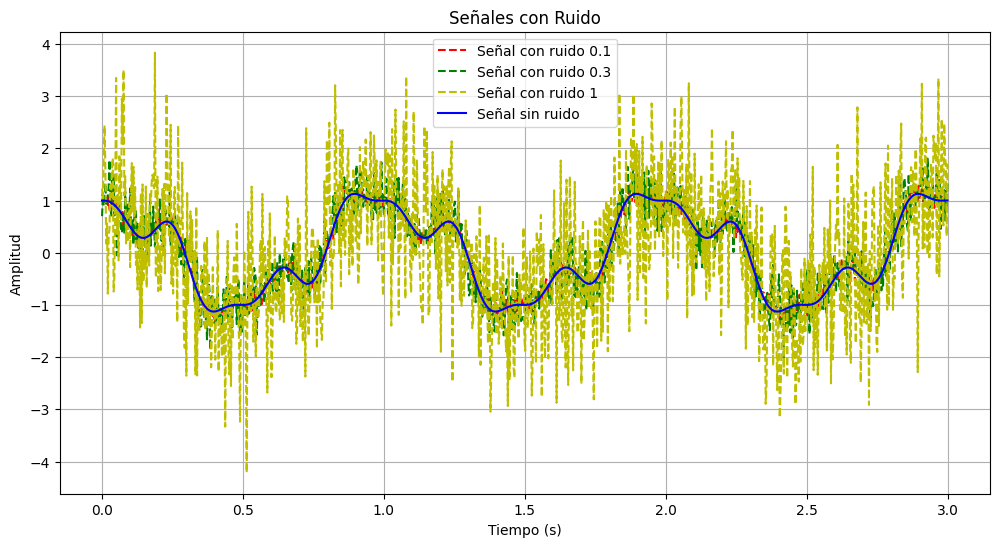

In [ ]:
#Verificación de las señales con ruido blanco gaussiano y la señal original
plt.figure(figsize=(12,6))
plt.title('Señales con Ruido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.plot(t,M01[0],'r', label = 'Señal con ruido 0.1', linestyle = '--')
plt.plot(t,M03[0], 'g', label = 'Señal con ruido 0.3', linestyle = '--')
plt.plot(t,M1[0], 'y',label = 'Señal con ruido 1', linestyle = '--')
plt.plot(t,xt, 'b', label = 'Señal sin ruido', linewidth=1.5)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#Calcular PSD con Welch a las señales con ruido creadas anteriormente
#Función que calcula el psd usando welch
def calcular_psd(senal, fs, nperseg):
    fr, Psd_den = welch(senal, fs=fs, nperseg=nperseg)
    return fr, Psd_den

In [ ]:
#PSD a la señal original
fr, Psd_xt = calcular_psd(xt, fs, N) #PSD señal original
fr, Psd_M01 = calcular_psd(M01, fs, N) #PSD señales con ruido 0.1
fr, Psd_M03 = calcular_psd(M03, fs, N) #PSD señales con ruido 0.3
fr, Psd_M1 = calcular_psd(M1, fs, N) #PSD señales con ruido 1

<ipython-input-13-6484ad0063bb>:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(10**-8,0)


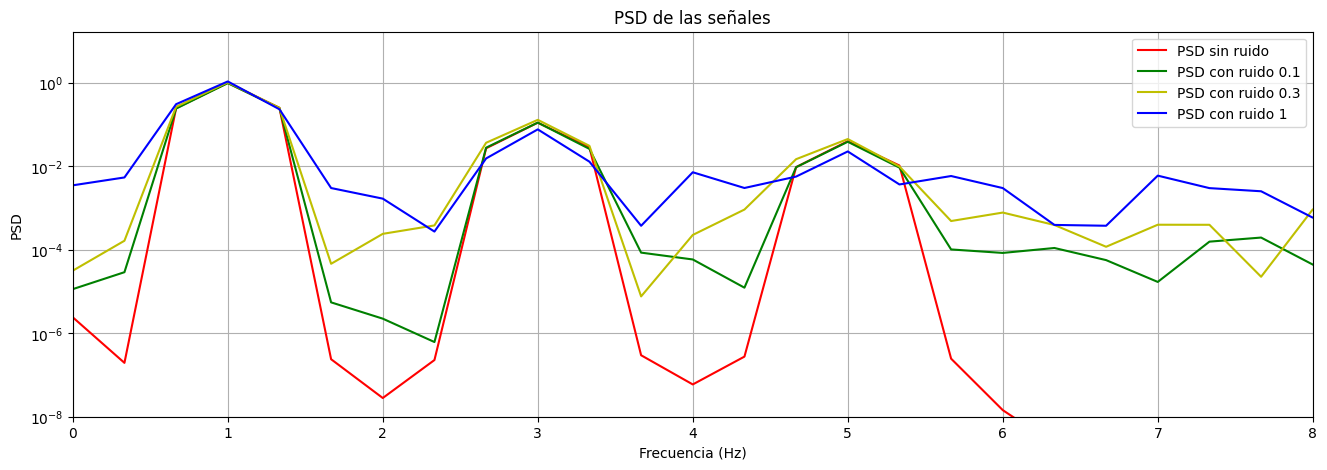

In [ ]:
#Visualización del PSD de las señales (original y con ruido)
plt.figure(figsize=(16,5))
plt.title('PSD de las señales')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD')
plt.semilogy(fr,Psd_xt, 'r', label="PSD sin ruido")
plt.semilogy(fr,Psd_M01[0],'g', label="PSD con ruido 0.1")
plt.semilogy(fr,Psd_M03[0],'y', label="PSD con ruido 0.3")
plt.semilogy(fr,Psd_M1[0],'b', label="PSD con ruido 1")
plt.xlim(0,8)
plt.ylim(10**-8,0)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#dimensiones de los datos(importante para la red) generar varias señales para el entrenamiento
print(len(xt)) #todas las señales tienen 1024 puntos (entrada de la red)
print(len(Psd_xt)) #todos los psd calculados tienen 513 puntos (salida de la red)

1024
513


# Creación de la red MLP para predecir PSD

In [ ]:
#Preparación de datos para construir el modelo Ruido 0.1
#Separación de datos
x01_train, x01_test, y01_train, y01_test = train_test_split(M01, Psd_M01, test_size=0.3, random_state=42)
#Funciones de escalamiento separados en entradas y salidas
scaler_x01 = MinMaxScaler()
scaler_y01 = MinMaxScaler()
#Escalamiento de las entradas
x01_train = scaler_x01.fit_transform(x01_train)
y01_train = scaler_y01.fit_transform(y01_train)
#Escalamiento de las salidas
x01_test = scaler_x01.transform(x01_test)
y01_test = scaler_y01.transform(y01_test)

In [ ]:
#Construcción modelos MLP para señales con ruido 0.1
model01=Sequential()
model01.add(Dense(512,activation='tanh',input_shape=(1024,)))
model01.add(Dense(128,activation='tanh'))
model01.add(Dense(64,activation='tanh'))
model01.add(Dense(513,activation='linear'))

model01.compile(optimizer=Adam(learning_rate=0.0001),loss='mse',metrics=['accuracy'])

history01=model01.fit(x01_train,y01_train,epochs=20, batch_size=15,validation_split=0.2)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0508 - val_accuracy: 0.0000e+00 - val_loss: 0.0419
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0013 - loss: 0.0408 - val_accuracy: 0.0000e+00 - val_loss: 0.0367
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0017 - loss: 0.0355 - val_accuracy: 0.0000e+00 - val_loss: 0.0312
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0048 - loss: 0.0301 - val_accuracy: 0.0000e+00 - val_loss: 0.0265
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0028 - loss: 0.0259 - val_accuracy: 0.0071 - val_loss: 0.0237
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0032 - loss: 0.0236 - val_accuracy: 0.0214 - val_loss: 0.0222
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0055 - loss: 0.0223 - val_accuracy: 0.0214 - val_loss: 0.0217
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0093 - loss: 0.0218 - val_accurac

In [ ]:
#Preparación de datos para construir el modelo
#Separación de datos
x03_train, x03_test, y03_train, y03_test = train_test_split(M03, Psd_M03, test_size=0.3, random_state=50)
#Funciones de escalamiento separados en entradas y salidas
scaler_x03 = MinMaxScaler()
scaler_y03 = MinMaxScaler()
#Escalado de las entradas
x03_train = scaler_x03.fit_transform(x03_train)
y03_train = scaler_y03.fit_transform(y03_train)
#Escalado de las salidas
x03_test = scaler_x03.transform(x03_test)
y03_test = scaler_y03.transform(y03_test)

In [ ]:
#Construcción modelos MLP para señales con ruido 0.3
model03=Sequential()
model03.add(Dense(128,activation='relu',input_shape=(1024,)))
model03.add(Dense(512,activation='relu'))
model03.add(Dense(513,activation='linear'))

model03.compile(optimizer=Adam(learning_rate=0.0001),loss='mse',metrics=['accuracy'])

history=model03.fit(x03_train,y03_train,epochs=20, validation_split=0.2)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0022 - loss: 0.0656 - val_accuracy: 0.0000e+00 - val_loss: 0.0392
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0072 - loss: 0.0370 - val_accuracy: 0.0071 - val_loss: 0.0307
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0075 - loss: 0.0291 - val_accuracy: 0.0143 - val_loss: 0.0252
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0081 - loss: 0.0245 - val_accuracy: 0.0143 - val_loss: 0.0231
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0228 - loss: 0.0225 - val_accuracy: 0.0143 - val_loss: 0.0225
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0163 - loss: 0.0221 - val_accuracy: 0.0143 - val_loss: 0.0222
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0182 - loss: 0.0219 - val_accuracy: 0.0214 - val_loss: 0.0221
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0116 - loss: 0.0217 - val_accuracy: 0.0143 - val_loss

In [ ]:
#Preparación de datos para construir el modelo
#Separación de datos
x1_train, x1_test, y1_train, y1_test = train_test_split(M1, Psd_M1, test_size=0.3, random_state=50)
#Funciones de escalamiento separados en entradas y salidas
scaler_x1 = MinMaxScaler()
scaler_y1 = MinMaxScaler()
#Escalado de las entradas
x1_train = scaler_x1.fit_transform(x1_train)
y1_train = scaler_y1.fit_transform(y1_train)
#Escalado de las salidas
x1_test = scaler_x1.transform(x1_test)
y1_test = scaler_y1.transform(y1_test)

In [ ]:
#Construcción modelos MLP para señales con ruido 1
model1=Sequential()
model1.add(Dense(128,activation='relu',input_shape=(1024,)))
model1.add(Dense(512,activation='relu'))
model1.add(Dense(513,activation='linear'))

#Compilación del modelo/red
model1.compile(optimizer=Adam(learning_rate=0.00001),loss='mse',metrics=['accuracy'])

#Ejecución del entrenamiento
history=model1.fit(x1_train,y1_train,epochs=35, validation_split=0.2)

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0848 - val_accuracy: 0.0000e+00 - val_loss: 0.0731
Epoch 2/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0711 - val_accuracy: 0.0071 - val_loss: 0.0628
Epoch 3/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0610 - val_accuracy: 0.0071 - val_loss: 0.0557
Epoch 4/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0551 - val_accuracy: 0.0071 - val_loss: 0.0507
Epoch 5/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0502 - val_accuracy: 0.0071 - val_loss: 0.0469
Epoch 6/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0461 - val_accuracy: 0.0071 - val_loss: 0.0439
Epoch 7/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0440 - val_accuracy: 0.0071 - val_loss: 0.0414
Epoch 8/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0413 -

# Loss

Perdida de Entrenamiento y Validación.

Text(0.5, 1.0, 'Model Loss')

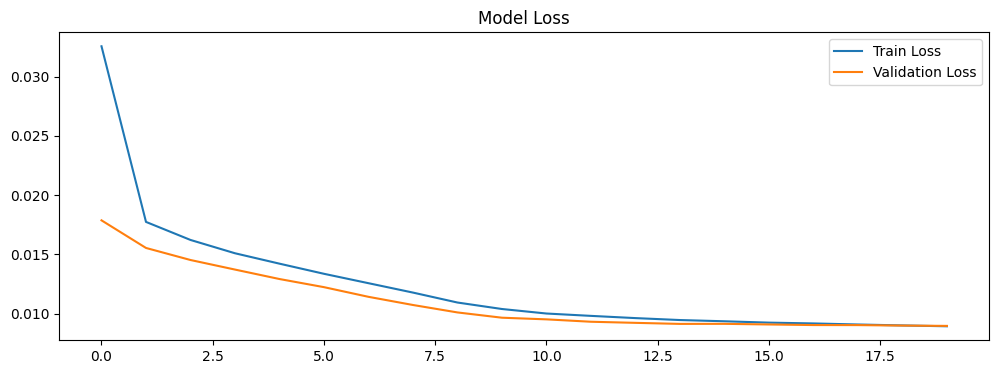

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

# Accuracy

Precisión del entrenamiento y validación.

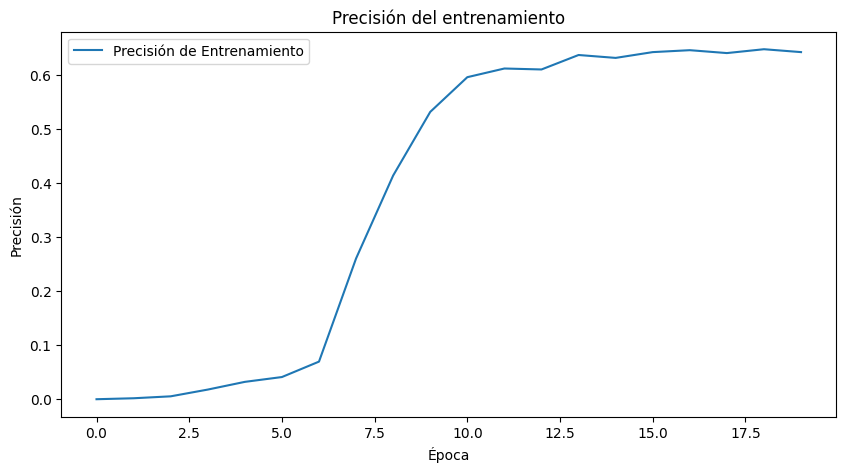

In [ ]:
#Visualización de la precisión del modelo
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.title('Precisión del entrenamiento')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Precisión de Entrenamiento'])
plt.show()

# Evaluación del modelo

Revisión del procentaje de precisión alcanzado con el entrenamiento y visualización de un resultado de PSD estimada con el modelo.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6587 - loss: 0.0099 


In [ ]:
y_pred = model.predict(x_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
y1 = scaler_y.inverse_transform(y_pred)

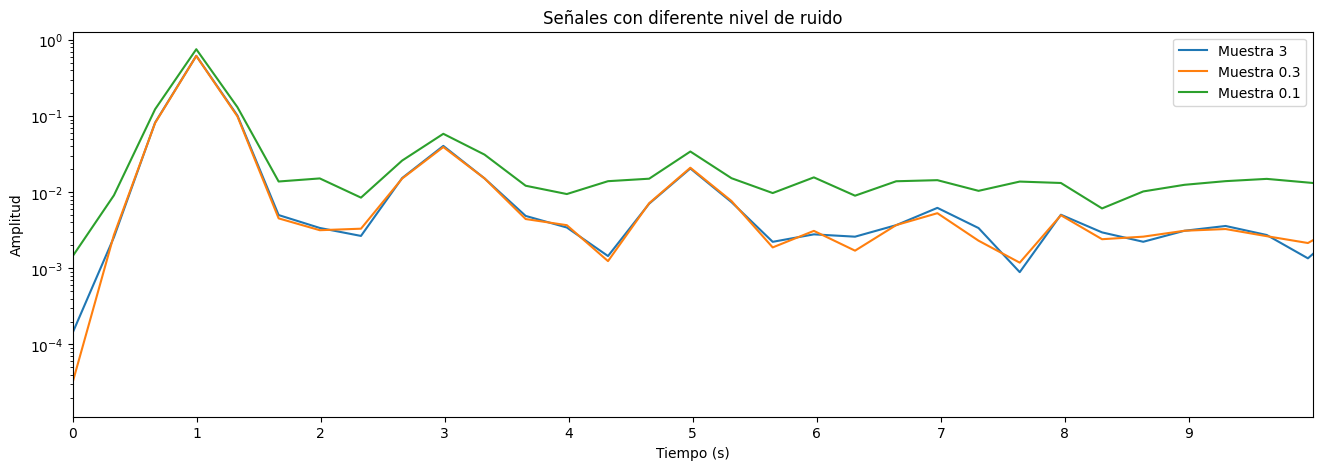

In [ ]:
#Visualización de las 1000 señales con ruido gaussiano
plt.figure(figsize=(16,5))
plt.title('Señales con diferente nivel de ruido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.semilogy(fr,y1[290], label="Muestra 3")
plt.semilogy(fr,y1[40], label="Muestra 0.3")
plt.semilogy(fr,y1[5], label="Muestra 0.1")
plt.xlim(0,10)
plt.xticks(np.arange(0,10,1))
plt.legend()
plt.show()

# Reconstrucción de la señal

In [ ]:
y1 = scaler_y.inverse_transform(y_pred)

In [ ]:
def reconstruct_signal(psd, N):
    # Asegurarse de que el PSD tenga la longitud correcta
    if len(psd) < N // 2 + 1:
        psd = np.pad(psd, (0, N // 2 + 1 - len(psd)), mode='constant')
    elif len(psd) > N // 2 + 1:
        psd = psd[:N // 2 + 1]

    # Crear el espectro completo (simétrico)
    full_psd = np.concatenate([psd, psd[-2:0:-1]])
    full_psd = np.clip(full_psd, a_min=0, a_max=None)  # Asegurarse de que no haya valores negativos

    # Convertir PSD a magnitudes
    magnitudes = np.sqrt(full_psd)

    # Generar fases aleatorias
    phases = np.random.uniform(0, 2*np.pi, len(magnitudes))

    # Crear el espectro complejo
    spectrum = magnitudes * np.exp(1j * phases)

    # Realizar la IFFT para obtener la señal en el dominio del tiempo
    reconstructed = np.fft.ifft(spectrum).real

    # Normalizar la señal reconstruida
    reconstructed = reconstructed - np.mean(reconstructed)
    reconstructed = reconstructed / np.std(reconstructed)

    return reconstructed

# Usar la función para reconstruir la señal
reconstructed_signal_real1 = reconstruct_signal(y1[200], N)
reconstructed_signal_real2 = reconstruct_signal(y1[50], N)

# Normalizar la señal original para una comparación justa
xt_normalized = (xt - np.mean(xt)) / np.std(xt)

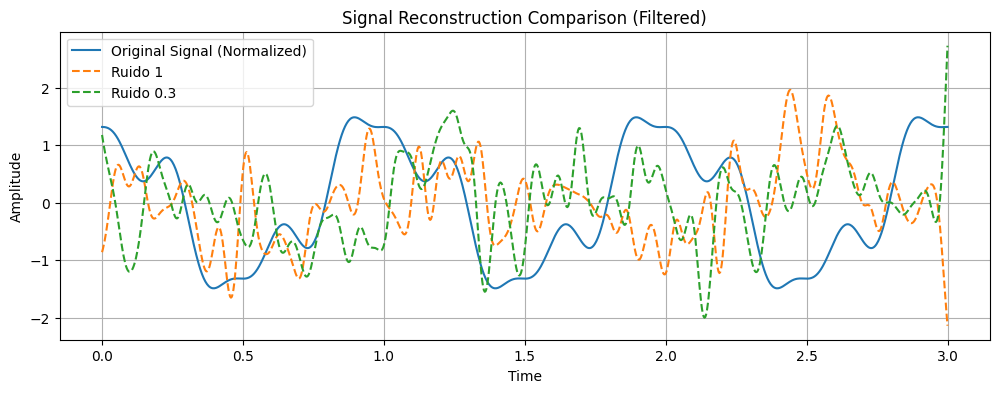

In [ ]:
#Filtro pasabajos para suavizar el ruido
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 400  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Usar la función de filtro de paso bajo después de reconstruir la señal
cutoff_freq = 30  # Frecuencia de corte para el filtro de paso bajo
reconstructed_signal_real_filtered1 = butter_lowpass_filter(reconstructed_signal_real1, cutoff=cutoff_freq, fs=T)*2
reconstructed_signal_real_filtered2 = butter_lowpass_filter(reconstructed_signal_real2, cutoff=cutoff_freq, fs=T)*2

# Graficar la comparación con la señal filtrada
plt.figure(figsize=(12, 4))
plt.plot(t, xt_normalized, label='Original Signal (Normalized)')
plt.plot(t, reconstructed_signal_real_filtered1, label='Ruido 1', linestyle="--")
plt.plot(t, reconstructed_signal_real_filtered2, label='Ruido 0.3',linestyle="--")
plt.title('Signal Reconstruction Comparison (Filtered)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()